In [20]:
import pandas as pd 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn import metrics
import numpy as np

In [ ]:
df = pd.read_csv('RTT_SUMMARY.csv')
print(df.head())

/var/folders/6t/7fh3k8d11691rn_615mmvwhr0000gn/T/ipykernel_7302/179018676.py:1: DtypeWarning: Columns (26,39) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('RTT_SUMMARY.csv')


   objectid  document_id             document_type            display_date  \
0   5002819     54475201        MISCELLANEOUS DEED  2025-10-06 14:56:58+00   
1   5002820     54475202                  MORTGAGE  2025-10-06 14:57:20+00   
2   5002821     54475203                  MORTGAGE  2025-10-06 14:59:46+00   
3   5002822     54475204  SATISFACTION OF MORTGAGE  2025-10-06 15:08:36+00   
4   5002823     54475205  SATISFACTION OF MORTGAGE  2025-10-06 15:09:12+00   

        street_address     zip_code  ward  \
0  7122 TORRESDALE AVE  191351313.0  41.0   
1      5812 JACKSON ST  191354029.0  55.0   
2         204 LONEY ST  191112234.0  63.0   
3     6050 N PHILIP ST  191201816.0  61.0   
4     229-35 S 52ND ST  191394107.0  60.0   

                                           grantors  \
0      BURDEN HYKEAM P;FREEDOM MORTGAGE CORPORATION   
1  SESSONS SONJIE DIONE;WATSON-SESSONS DANIELLE M C   
2                   KOLLA JOHN F JR;KOLLA LINDSAY M   
3                                    CUS

In [8]:
# Get the column names
df.columns

Index(['objectid', 'document_id', 'document_type', 'display_date',
       'street_address', 'zip_code', 'ward', 'grantors', 'grantees',
       'cash_consideration', 'other_consideration', 'total_consideration',
       'assessed_value', 'common_level_ratio', 'fair_market_value',
       'state_tax_amount', 'state_tax_percent', 'local_tax_amount',
       'local_tax_percent', 'adjusted_cash_consideration',
       'adjusted_other_consideration', 'adjusted_total_consideration',
       'adjusted_assessed_value', 'adjusted_fair_market_value',
       'adjusted_state_tax_amount', 'adjusted_local_tax_amount', 'receipt_num',
       'receipt_date', 'recording_date', 'document_date', 'condo_name',
       'unit_num', 'address_low', 'address_low_suffix', 'address_low_frac',
       'address_high', 'street_predir', 'street_name', 'street_suffix',
       'street_postdir', 'reg_map_id', 'matched_regmap', 'opa_account_num',
       'legal_remarks', 'discrepancy', 'property_count', 'record_id', 'lat',
      

In [ ]:
# create a new table with selected columns
table = df[[
  "total_consideration",              # sale price
  "adjusted_fair_market_value",       # assessed value
  "recording_date",                   # date of sale
  "street_address",                   # property address
  "zip_code",                         # property zip code
  "ward",                             # electoral district
  "lat",                              # latitude
  "lng",                              # longitude
  "opa_account_num"                   # unique property identifier
]]

# remove columns with $1 and $0 values
table = table[
    (table["total_consideration"].notna()) &
    (table["total_consideration"] > 10000) &
    (table["opa_account_num"].notna())
]

# convert recording_date to datetime format
table["recording_date"] = pd.to_datetime(table["recording_date"], errors="coerce")

# drop missing values -> every row must have a recording date
table = table.dropna(subset=["recording_date"])

# print the cleaned table
print(table.head())

    total_consideration  adjusted_fair_market_value            recording_date  \
36             315000.0                    292700.0 2025-10-06 16:07:02+00:00   
51             270000.0                    227500.0 2025-10-06 16:14:43+00:00   
53             370201.0                    316500.0 2025-10-06 16:17:18+00:00   
58             215000.0                    208400.0 2025-10-06 16:31:32+00:00   
63             195000.0                    141000.0 2025-10-06 16:33:07+00:00   

        street_address     zip_code  ward        lat        lng  \
36    4274 LAWNSIDE RD  191542804.0  66.0  40.081624 -74.968825   
51  2021 E SERGEANT ST  191251317.0  31.0  39.985756 -75.126114   
53      9972 BRIDLE RD  191151303.0  58.0  40.105662 -75.037315   
58  2214 S COLORADO ST  191453809.0  26.0  39.923478 -75.175568   
63     2305 BUCKIUS ST  191371201.0  45.0  40.007811 -75.073656   

    opa_account_num  
36      662610200.0  
51      314087900.0  
53      581231200.0  
58      262033100.0  


In [10]:
# save the data to a new CSV file
table.to_csv("philly_sales_clean_2020_present.csv", index=False)

In [ ]:
# display summary statistics
df.describe()

# count = number of non-missing values
# mean = average value 
# std = standard deviation
# min = minimum value
# 25% = first quartile
# 50% = median
# 75% = third quartile
# max = maximum value, outliers may be present

,objectid,document_id,zip_code,ward,cash_consideration,other_consideration,total_consideration,assessed_value,common_level_ratio,fair_market_value,...,adjusted_fair_market_value,adjusted_state_tax_amount,adjusted_local_tax_amount,address_low,address_high,opa_account_num,property_count,record_id,lat,lng
count,1.040504e+06,1.040504e+06,8.999720e+05,966492.000000,8.299400e+05,2.317140e+05,8.299410e+05,2.350870e+05,2.298860e+05,2.350880e+05,...,2.350840e+05,2.298830e+05,2.287580e+05,1.013400e+06,53630.000000,9.180560e+05,1.040504e+06,1.040504e+06,966503.000000,966503.000000
mean,4.508344e+06,5.405772e+07,1.913321e+08,33.452003,1.398356e+05,4.863709e+03,1.411934e+05,2.182322e+06,3.680702e+01,2.747299e+06,...,2.203792e+06,2.579373e+03,8.356530e+03,3.244185e+03,38.626067,4.309688e+08,9.815328e+00,1.049823e+11,39.997895,-75.145417
std,3.010499e+05,2.591718e+05,8.887329e+05,19.113969,2.543499e+06,7.741155e+05,2.615261e+06,6.649846e+08,9.558758e+03,6.755076e+08,...,6.754681e+08,2.136169e+04,6.421419e+04,5.718187e+04,184.644459,2.524419e+08,5.765723e+01,2.364390e+13,0.051053,0.065821
min,1.000000e+00,1.800000e+01,1.910400e+04,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000,1.100002e+07,1.000000e+00,1.800000e+02,39.880570,-75.274394
25%,4.247698e+06,5.384084e+07,1.912324e+08,18.000000,0.000000e+00,0.000000e+00,0.000000e+00,6.760000e+04,1.000000e+00,6.890800e+04,...,5.896659e+04,1.000000e-02,5.000000e-02,1.102000e+03,16.000000,2.320340e+08,1.000000e+00,5.385040e+08,39.955775,-75.184300
50%,4.508470e+06,5.405580e+07,1.913457e+08,34.000000,0.000000e+00,0.000000e+00,0.000000e+00,1.512000e+05,1.060000e+00,1.557920e+05,...,1.355310e+05,1.350000e+03,4.507250e+03,2.215000e+03,27.000000,4.022511e+08,1.000000e+00,5.408127e+08,39.989927,-75.158152
75%,4.769029e+06,5.427688e+07,1.914520e+08,50.000000,1.000000e+00,0.000000e+00,1.000000e+00,2.710000e+05,1.070000e+00,2.789710e+05,...,2.410710e+05,2.800000e+03,9.178400e+03,4.609000e+03,40.000000,5.921410e+08,1.000000e+00,5.431486e+08,40.038998,-75.109206
max,5.029454e+06,5.449547e+07,1.919200e+08,66.000000,5.506416e+08,2.090000e+08,5.506416e+08,3.224000e+11,4.485500e+06,3.224000e+11,...,3.224000e+11,5.506416e+06,1.805003e+07,4.418415e+07,10175.000000,8.888006e+08,1.016000e+03,5.393140e+15,40.137716,-74.958769


In [12]:
# define features and target variable 

# features: lng, lat, zip_code, ward, adjusted_fair_market_value i.e locational and assessed value data
# what the model will use to predict sale price
X = table[[
    "lng",          
    "lat",
    "zip_code",
    "ward",
    "adjusted_fair_market_value",
]]

# target variable: total_consideration
Y = table["total_consideration"]

In [ ]:
# compute the correlation matrix 
# want to see how features are correlated with each other
correlation = X.corr()
correlation

,lng,lat,zip_code,ward,adjusted_fair_market_value
lng,1.000000,0.615458,-0.008321,0.496023,0.001780
lat,0.615458,1.000000,-0.019698,0.421254,-0.000500
zip_code,-0.008321,-0.019698,1.000000,0.005350,-0.000258
ward,0.496023,0.421254,0.005350,1.000000,-0.003633
adjusted_fair_market_value,0.001780,-0.000500,-0.000258,-0.003633,1.000000


<Axes: >

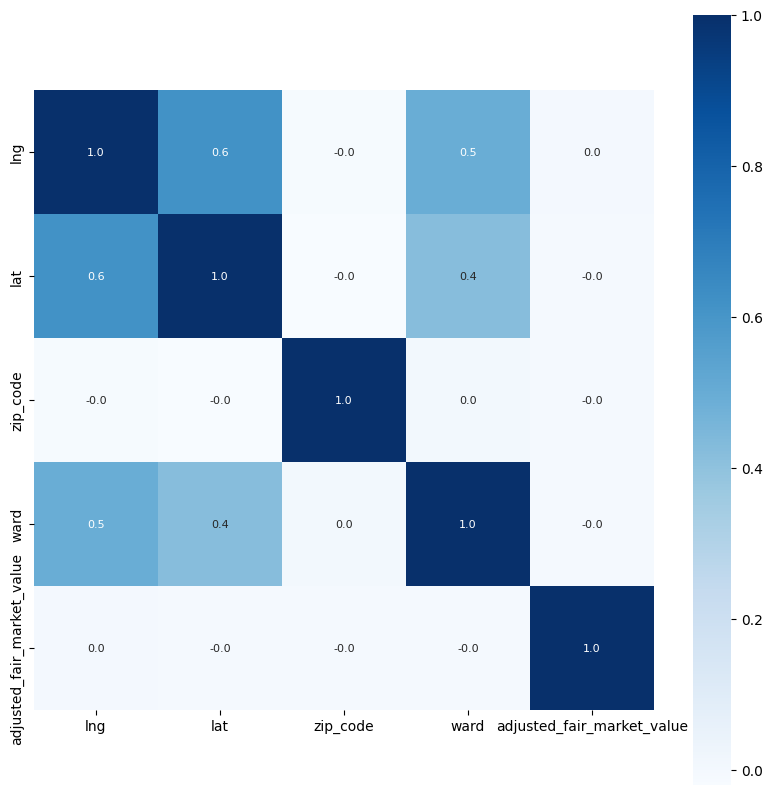

In [ ]:
# make a heatmap to visualize the correlation matrix
plt.figure(figsize=(10,10))
sns.heatmap(correlation, cbar=True, square=True, fmt='.1f', annot=True, annot_kws={'size':8}, cmap='Blues')

# the heatmap shows the correlation coefficients between each pair of features
# 1 = perfect positive correlation
# -1 = perfect negative correlation
# 0 = no correlation
# from this heatmap, we can see that lat and lng are not strongly correlated with any other features which is expected in philadephila 
# location and ward are redundant since ward is a function of location
# correlation treats the zipcodes as random numbers so we should be careful interpreting the correlation values for zip_code
# adjusted fair market value has some correlation but not very strong with total consideration becasuse correlation is global not local

In [15]:
# print the split data set from the previous cell -> show features and target variable
print(X, Y)

               lng        lat     zip_code  ward  adjusted_fair_market_value
36      -74.968825  40.081624  191542804.0  66.0                    292700.0
51      -75.126114  39.985756  191251317.0  31.0                    227500.0
53      -75.037315  40.105662  191151303.0  58.0                    316500.0
58      -75.175568  39.923478  191453809.0  26.0                    208400.0
63      -75.073656  40.007811  191371201.0  45.0                    141000.0
...            ...        ...          ...   ...                         ...
1040483 -75.055810  40.017455  191353708.0  41.0                    126600.0
1040492 -75.108510  40.015094  191243817.0  33.0                    126000.0
1040494 -75.194137  39.926559  191452433.0  48.0                    109300.0
1040496 -75.226743  39.939131  191434703.0  51.0                    118800.0
1040497 -75.190025  39.932535  191451217.0  36.0                    151000.0

[155518 rows x 5 columns] 36         315000.0
51         270000.0
53       

In [ ]:
# split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
# 80% training data, 20% testing data 

# print the shapes of the datasets -> view the samples and features  
print(X.shape, X_train.shape, X_test.shape)

(155518, 5) (124414, 5) (31104, 5)


In [ ]:
# load the model
model = XGBRegressor()

# training the model with X_train
model.fit(X_train, Y_train)

# this shows the model has been trained on the training data 

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,None
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes

In [ ]:
# accuracy for prediction on training data
training_data_prediction = model.predict(X_train)

# this prints the predicted sale prices for the training data
print(training_data_prediction)

[139216.4  414746.75 273428.53 ... 509937.06 595298.8  290538.97]


In [32]:
# R Squared Error -> how well the model explains the variance in the data
score_1 = metrics.r2_score(Y_train, training_data_prediction)

# Mean Absolute Error -> average absolute difference between predicted and actual values
score_2 = metrics.mean_absolute_error(Y_train, training_data_prediction)

print('R Sqaured Error:', score_1) # closer to 1 is better
print('Mean Absolute Error:', score_2)  # closer to 0 is better

R Sqaured Error: 0.9506884128469397
Mean Absolute Error: 259605.80086564607


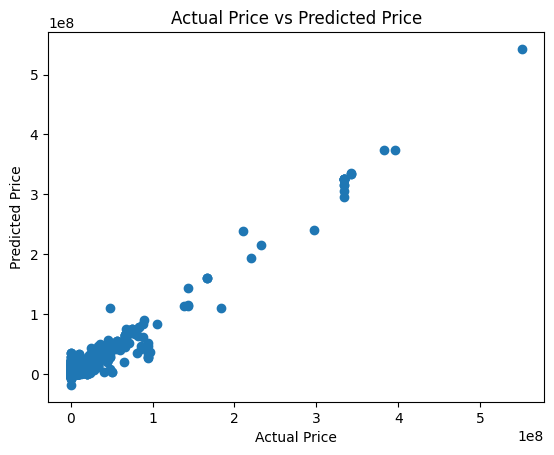

In [ ]:
# visualize the actual vs predicted prices
plt.scatter(Y_train, training_data_prediction)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual Price vs Predicted Price")
plt.show()

In [34]:
# accuracy for prediction on test data
test_data_prediction = model.predict(X_test)

In [35]:
# R Squared Error
score_1 = metrics.r2_score(Y_test, test_data_prediction)

# Mean Absolute Error
score_2 = metrics.mean_absolute_error(Y_test, test_data_prediction)

print('R Sqaured Error:', score_1)
print('Mean Absolute Error:', score_2)

R Sqaured Error: 0.7220270042331303
Mean Absolute Error: 338167.20342926134
